# I&I TP4 - Data Exploration

Cette partie est dédiée à l'exploration du jeu de données, et à la création d'un DataLoader.

# 1 - Librairie, drive, paths et device

Installation des librairies

In [ ]:
#@title
!pip install pystoi
!pip install pesq
!pip install torchmetrics

Import des librairies

In [ ]:
#@title
# Libraries
import os
import json
import math
import random
import librosa 
import soundfile as sf
import IPython.display as ipd
import matplotlib.pylab as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.audio.stoi import ShortTimeObjectiveIntelligibility
from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality

import numpy as np
from numpy import linalg
from datetime import date

Google Drive pour l'accès aux données

In [64]:
#@title
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Initilisation des chemins importants

In [9]:
#@title
# Important paths
# Project path
path_project = "/content/drive/MyDrive/ENS_MVA/II_Signal/TP4"
path_models = os.path.join(path_project, 'models')
path_img = os.path.join(path_project, 'img')

# Voix
path_voix_test = "/content/drive/MyDrive/ENS_MVA/II_Signal/TP4/data/voix_test/test"
path_voix_train = "/content/drive/MyDrive/ENS_MVA/II_Signal/TP4/data/voix_train/train"

# Bruit
path_bruit_test = "/content/drive/MyDrive/ENS_MVA/II_Signal/TP4/data/bruit_test/test"
path_bruit_train = "/content/drive/MyDrive/ENS_MVA/II_Signal/TP4/data/bruit_train/train"

Choix du device utilisé

In [ ]:
#@title
# Select cuda (GPU) if available, else use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device available: {device}')

Device available: cuda:0


# 2 - Chargement des données : Loader

Cette partie est consacrée à la lecture des données. 

Les classes d'objet : dataset, laoder seront définies afin d'être adaptées au problème.

- Fonction 'get_data' pour créer un mix à partir de la voix et du bruit.

In [ ]:
#@title
def get_data(y_bruit, y_voix):
  '''
  A partir du bruit et d'une voix:
  -> Renvoie mix normalisé, (voix normalisée, bruit normalisé).
  Input:
    y_bruit : amplitude du bruit
    y_voix : amplitude de la voix
  Return:
    mix normalisé, (voix normalisée, bruit normalisé)
  '''
  # Normalize
  y_voix_norm = y_voix/linalg.norm(y_voix)
  y_bruit_norm = y_bruit/linalg.norm(y_bruit)

  # Mix 
  alpha = random.uniform(0.6, 0.9) # coeff du bruit
  y_mix = y_voix_norm + alpha*y_bruit_norm
  # Normalize Mix
  y_bruit_norm = y_bruit/linalg.norm(y_bruit_norm)

  return y_mix, (y_voix_norm, y_bruit_norm)

## 2.1 - Class object : Custom dataset

Ces classes permettent de load les données de train et de test avec un dataset Pytorch.

### 2.1.1 - Dataset - Train

In [ ]:
#@title
class TrainDataset(Dataset):
    '''
    Class to get train set as dataset
    '''
    def __init__(self):
        '''
        Initialize dataset
        '''
        # List which contains path of (voix, bruit)
        self.data = []
        # Important paths
        self.path_voix_train = path_voix_train
        self.path_bruit_train = path_bruit_train

        # For each voice file
        for file in os.listdir(self.path_voix_train):
          filename_voix = os.fsdecode(file) # filename
          if filename_voix.endswith(".wav"):
            # Path de la voix
            filename_voix = os.path.join(self.path_voix_train, filename_voix)
            # Path du bruit
            filename_bruit = os.path.join(self.path_bruit_train, random.choice(os.listdir(self.path_bruit_train)))   
            # Add the file
            self.data.append([filename_voix, filename_bruit])

    def __len__(self):
        '''
        return len of current data
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Load and generate normalized mix audio from bruit and voice
        '''
        # Get path to load data
        filename_voix, filename_bruit = self.data[idx]

        # Load data
        y_voix, _ = librosa.load(path=filename_voix, sr=None)
        y_bruit, _ = librosa.load(path=filename_bruit, sr=None)

        # Normalize data with mix
        y_mix_norm, (y_voix_norm, y_bruit_norm) = get_data(y_bruit, y_voix)

        # ToTensor
        y_mix_tensor = torch.tensor(y_mix_norm)
        y_voix_tensor = torch.from_numpy(y_voix_norm)
        y_bruit_tensor = torch.from_numpy(y_bruit_norm)

        # to device
        y_mix_tensor = y_mix_tensor.to(device)
        y_voix_tensor = y_voix_tensor.to(device)
        y_bruit_tensor = y_bruit_tensor.to(device)

        return y_mix_norm, (y_voix_tensor, y_bruit_tensor)

### 2.1.2 - Dataset - Test

In [ ]:
#@title
class TestDataset(Dataset):
    '''
    Class to get test set as dataset
    '''
    def __init__(self):
        '''
        Initialize dataset
        '''
        # List which contains path of (voix, bruit)
        self.data = []
        # Important paths
        self.path_voix_test = path_voix_test
        self.path_bruit_test = path_bruit_test

        # For each voice file
        for file in os.listdir(self.path_voix_test):
          filename_voix = os.fsdecode(file) # filename
          if filename_voix.endswith(".wav"):
            # Path de la voix
            filename_voix = os.path.join(self.path_voix_test, filename_voix)
            # Path du bruit
            filename_bruit = os.path.join(self.path_bruit_test, random.choice(os.listdir(self.path_bruit_test)))   
            # Add the file
            self.data.append([filename_voix, filename_bruit])

    def __len__(self):
        '''
        return len of current data
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
        Load and generate normalized mix audio from bruit and voice
        '''
        # Get path to load data
        filename_voix, filename_bruit = self.data[idx]

        # Load data
        y_voix, _ = librosa.load(path=filename_voix, sr=None)
        y_bruit, _ = librosa.load(path=filename_bruit, sr=None)

        # Normalize data with mix
        y_mix_norm, (y_voix_norm, y_bruit_norm) = get_data(y_bruit, y_voix)

        # ToTensor
        y_mix_tensor = torch.tensor(y_mix_norm)
        y_voix_tensor = torch.from_numpy(y_voix_norm)
        y_bruit_tensor = torch.from_numpy(y_bruit_norm)

        # to device
        y_mix_tensor = y_mix_tensor.to(device)
        y_voix_tensor = y_voix_tensor.to(device)
        y_bruit_tensor = y_bruit_tensor.to(device)

        return y_mix_norm, (y_voix_tensor, y_bruit_tensor)

### 2.2 Initialize datasets and load DataLoader

In [ ]:
#@title
# Initialize & load Dataloader

# Train
dataset_train = TrainDataset()
data_loader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

# Test
dataset_test = TestDataset()
data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True)

print(f'Train & Test loader loaded successfully!')

Train & Test loader loaded successfully!


### 2.3 Iterate over DataLoader to check it is fine, for batch_size=1

In [ ]:
#@title
# Check iteration number
j = 0
for batch_id, data in enumerate(data_loader_train):

  # get mix, (voix, bruit) from data
  mix, (voix, bruit) = data
  mix, voix, bruit = mix[0], voix[0], bruit[0]

  break

### 2.3 Iterate over DataLoader to check it is fine, for batch_size>1

In [ ]:
#@title
# Input size for the model
input_size = 16384
for batch_id, data in enumerate(data_loader_train):

  # get mix, (voix, bruit) from data
  mix, (voix, bruit) = data

  # add a dimension for the batch
  mix = mix[:, None, :]
  voix = voix[:, None, :]
  bruit = bruit[:, None, :]

  # modify input shape for wave-u-net
  mix1, mix2, mix3, mix4 = mix[:, :, :input_size], mix[:, :, (input_size+1):2*input_size+1], mix[:, :, (2*input_size+2):3*input_size+2], mix[:, :, (3*input_size+3):4*input_size+3]
  voix1, voix2, voix3, voix4 = voix[:, :, :input_size], voix[:, :, (input_size+1):2*input_size+1], voix[:, :, (2*input_size+2):3*input_size+2], voix[:, :, (3*input_size+3):4*input_size+3]
  bruit1, bruit2, bruit3, bruit4 = bruit[:, :, :input_size], bruit[:, :, (input_size+1):2*input_size+1], bruit[:, :, (2*input_size+2):3*input_size+2], bruit[:, :, (3*input_size+3):4*input_size+3]
  mix = torch.cat((mix1, mix2, mix3, mix4), 0)
  voix = torch.cat((voix1, voix2, voix3, voix4), 0)
  bruit = torch.cat((bruit1, bruit2, bruit3, bruit4), 0)

  break

In [ ]:
#@title
# Input size for the model
input_size = 16384
for batch_id, data in enumerate(data_loader_train):
  pass
  # get mix, (voix, bruit) from data
  mix, (voix, bruit) = data

  # add a dimension for the batch
  mix = mix[:, None, :]
  voix = voix[:, None, :]
  bruit = bruit[:, None, :]

  # modify input shape for wave-u-net
  mix = mix[:, :, :input_size]
  voix = voix[:, :, :input_size]
  bruit = bruit[:, :, :input_size]

  # break

# 3 - Architecture du modèle

Cette partie est consacrée à l'implémentation du modèle Wave-U-Net (https://arxiv.org/abs/1806.03185).

Le modèle est composé de différents blocks de sampling. Ainsi, les blocks de sampling sont tout d'abord définies sous forme de classe PyTorch, et ensuite le modèle Wave-U-Net sera défini.

## 3.1 - Blocks de Sampling

Implémentation des blocks de Down/Up Sampling

### 3.1.1 - DownSampling Block

Implémentation de la classe de DownSampling

In [ ]:
#@title
class DownSamplingLayer(nn.Module):
    '''
      Implémentation d'une couche de DownSampling
    '''
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        '''
        Initialize UpSamplingLayer.
        Same parameters/architecture of Wave-U-Net.
        '''
        super(DownSamplingLayer, self).__init__()

        # Convolution layer
        self.conv = nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        # BatchNorm 1d
        self.batchnorm = nn.BatchNorm1d(channel_out)
        # WeakyRelu as activation function
        self.relu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, input):
        '''
        Forward propagation of the DownSamplingLayer.
        Input:
          input: input of the layer.
        Return:
          output: output of the layer.
        '''
        # Convolution layer
        output = self.conv(input)
        # BatchNorm after conv. layer
        output = self.batchnorm(output)
        # Activation function: LeakyReLU
        output = self.relu(output)
        
        return output

### 3.1.2 - UpSampling Block

Implémentation de la classe de UpSampling

In [ ]:
#@title
class UpSamplingLayer(nn.Module):
    '''
      Implémentation d'une couche de UpSampling
    '''
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        '''
        Initialize UpSamplingLayer.
        Same parameters/architecture of Wave-U-Net.
        '''
        super(UpSamplingLayer, self).__init__()
        # Convolution layer
        self.conv = nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding)
        # BatchNorm 1d
        self.batchnorm = nn.BatchNorm1d(channel_out)
        # WeakyRelu as activation function
        self.relu = nn.LeakyReLU(negative_slope=0.1)

    def forward(self, input):
        '''
        Forward propagation of the UpSamplingLayer
        Input:
          input: input of the layer.
        Return:
          output: output of the layer.
        '''
        # Convolution Layer
        output = self.conv(input)
        # BatchNorm to output of conv. layer
        output = self.batchnorm(output)
        # Activation function: LeakyReLU
        output = self.relu(output)
        
        return output

## 3.2 - Le modèle

Architecture du modèle Wave-U-Net ci-dessous.

In [ ]:
#@title
class Model(nn.Module):
    '''
    torch model : implementation of wave-U-net
    '''
    def __init__(self, nb_layers=12, channels_interval=24):
        '''
        Initialize the model : Wave-U-Net.
        Input -> DownSampling -> Middle -> UpSampling -> Prediction.
        Input:
          nb_layers: number of layers for Down/Up Sampling blocks.
          channels_interval=Interval for channels.
        '''
        super(Model, self).__init__()

        # Number of layers
        self.nb_layers = nb_layers
        # Channels Interval
        self.channels_interval = channels_interval

        # Initialize encoders as list for DownSampling layers
        encoder_in_channels_list = [1] + [layer * self.channels_interval for layer in range(1, self.nb_layers)]
        encoder_out_channels_list = [layer * self.channels_interval for layer in range(1, self.nb_layers + 1)]

        # Iterate over DownSampling layers (nb_layers)
        self.encoder = nn.ModuleList()
        for layer in range(self.nb_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[layer],
                    channel_out=encoder_out_channels_list[layer]))

        # Block between DownSampling Blocks and UpSampling Blocks
        self.middle = nn.Sequential(
            nn.Conv1d(self.nb_layers * self.channels_interval, self.nb_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.nb_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True))

        # Initialize decoders as list for UpSampling layers
        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.nb_layers)] + [
            2 * self.nb_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]

        # Iterate over UpSampling layers (nb_layers)
        self.decoder = nn.ModuleList()
        for layer in range(self.nb_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[layer],
                    channel_out=decoder_out_channels_list[layer]))

        # Output Layer
        self.output_layer = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh())

    def forward(self, input):
        '''
        Forward propagation of the network. 
        Input -> DownSampling -> Middle -> UpSampling -> Prediction.
        Input: 
          input: batched data input (samples of audio files) : mix audio.
        Return: 
          Output: estimation of voice audio without noise.
        '''
        tmp = []
        output = input

        # Block for DownSampling
        for layer in range(self.nb_layers):
            # Encoder layer - DownSampling
            output = self.encoder[layer](output)
            tmp.append(output)
            # Reshape tensor
            output = output[:, :, ::2]

        # Middle block
        output = self.middle(output)

        # Block for UpSampling
        for layer in range(self.nb_layers):
            output = F.interpolate(output, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection - Decoder layer
            output = torch.cat([output, tmp[self.nb_layers - layer - 1]], dim=1)
            output = self.decoder[layer](output)

        # Output layer
        output = torch.cat([output, input], dim=1)
        output = self.output_layer(output)

        return output

# 3 - Entrainement du modèle

## 3.1 - Phase d'entrainement

Avant de commencer, initialiser le modèle et utiliser le bon device.

In [ ]:
# Initialisation du modèle
nb_layers, channels_interval = 10, 24 # 12 layers and 24 channels interval
model = Model(nb_layers, channels_interval)
model = model.to(device)

print(f'Modèle chargé sur {device} avec succès!')

Modèle chargé sur cuda:0 avec succès!


## 3.2 - Train & Test fonctions

Définition de la métrique STOI pour évaluer les performances du modèle

In [ ]:
#@title
#@title
sr_files = 8000 # sampling rate of files

# stoi from torchmetrics
stoi = ShortTimeObjectiveIntelligibility(sr_files, False) 

# pesq from torchmetrics
nb_pesq = PerceptualEvaluationSpeechQuality(sr_files, 'nb')

Définition de la fonction de train

In [ ]:
#@title

# Train function
def train(epoch, network, train_loader, optimizer):
    '''
    Train the model for a given epoch, a given model network and data.
    Input:
      epoch: current epoch.
      network: Neural Network model.
      train_loader: DataLoader.
    Return:
      loss_epoch: sum of losses for the current epoch.
    '''
    # Model as train mode to update parameters
    network.train()
    
    # Initialize metrics
    loss_epoch = 0 # Initialize loss_epoch which computes total loss for given epoch
    stoi_epoch = 0 # Initialize STOI to 0
    pesq_epoch = 0 # Initialize PESQ to 0

    for batch_id, data in enumerate(train_loader):

      # get mix, (voix, bruit) from data
      mix, (voix, bruit) = data

      # add a dimension for the batch
      mix = mix[:, None, :]
      voix = voix[:, None, :]
      bruit = bruit[:, None, :]

      # modify input shape for wave-u-net
      mix = mix[:, :, :input_size]
      voix = voix[:, :, :input_size]
      bruit = bruit[:, :, :input_size]

      # to cuda
      mix = mix.to(device)

      # make a prediction
      pred = network(mix)

      # Compute loss and backward propagation
      optimizer.zero_grad()
      loss = loss_function(voix, pred) # average loss of current batch
      loss.backward()
      optimizer.step()

      # Sum losses
      loss_epoch += loss.item()

      # Compute STOI, PESQ
      stoi_current = stoi(voix, pred)
      stoi_epoch += stoi_current.item() # STOI
      pesq_current = torch.tensor(0) # nb_pesq(voix, mix)
      pesq_epoch += pesq_current.item() # PESQ

      return loss_epoch, stoi_epoch, pesq_epoch

Définition de la fonction de test

In [ ]:
#@title

# Test function
def test(epoch, network, test_loader):
    '''
    Train the model for a given epoch, a given model network and data.
    Input:
      epoch: current epoch.
      network: Neural Network model.
      test_loader: DataLoader.
    Return:
      loss_epoch: sum of losses for the current epoch.
    '''
    # Model as eval mode to avoid update parameters
    network.eval()
    
    # Initialize metrics
    loss_epoch = 0 # Initialize loss_epoch which computes total loss for given epoch
    stoi_epoch = 0 # Initialize STOI to 0
    pesq_epoch = 0 # Initialize PESQ to 0

    for batch_id, data in enumerate(test_loader):

      # get mix, (voix, bruit) from data
      mix, (voix, bruit) = data

      # add a dimension for the batch
      mix = mix[:, None, :]
      voix = voix[:, None, :]
      bruit = bruit[:, None, :]

      # modify input shape for wave-u-net
      mix = mix[:, :, :input_size]
      voix = voix[:, :, :input_size]
      bruit = bruit[:, :, :input_size]

      # to cuda
      mix = mix.to(device)

      # make a prediction
      pred = network(mix)

      # Compute loss for the given prediction
      loss = loss_function(voix, pred) # average loss of current batch

      # Sum losses
      loss_epoch += loss.item()

      # Compute STOI, PESQ
      stoi_current = stoi(voix, pred)
      stoi_epoch += stoi_current.item() # STOI
      pesq_current = torch.tensor(0) # nb_pesq(voix, mix)
      pesq_epoch += pesq_current.item() # PESQ

      return loss_epoch, stoi_epoch, pesq_epoch

Définition de la fonction de train - batch*4

In [ ]:
#@title

# Train function
def train(epoch, network, train_loader, optimizer):
    '''
    Train the model for a given epoch, a given model network and data.
    Input:
      epoch: current epoch.
      network: Neural Network model.
      train_loader: DataLoader.
    Return:
      loss_epoch: sum of losses for the current epoch.
    '''
    # Model as train mode to update parameters
    network.train()
    
    # Initialize metrics
    loss_epoch = 0 # Initialize loss_epoch which computes total loss for given epoch
    stoi_epoch_pred, stoi_epoch_mix = 0, 0 # Initialize STOI to 0

    for batch_id, data in enumerate(train_loader):

      # get mix, (voix, bruit) from data
      mix, (voix, bruit) = data

      # add a dimension for the batch
      mix = mix[:, None, :]
      voix = voix[:, None, :]
      bruit = bruit[:, None, :]

      # modify input shape for wave-u-net
      mix1, mix2, mix3, mix4 = mix[:, :, :input_size], mix[:, :, (input_size+1):2*input_size+1], mix[:, :, (2*input_size+2):3*input_size+2], mix[:, :, (3*input_size+3):4*input_size+3]
      voix1, voix2, voix3, voix4 = voix[:, :, :input_size], voix[:, :, (input_size+1):2*input_size+1], voix[:, :, (2*input_size+2):3*input_size+2], voix[:, :, (3*input_size+3):4*input_size+3]
      bruit1, bruit2, bruit3, bruit4 = bruit[:, :, :input_size], bruit[:, :, (input_size+1):2*input_size+1], bruit[:, :, (2*input_size+2):3*input_size+2], bruit[:, :, (3*input_size+3):4*input_size+3]
      mix = torch.cat((mix1, mix2, mix3, mix4), 0)
      voix = torch.cat((voix1, voix2, voix3, voix4), 0)
      bruit = torch.cat((bruit1, bruit2, bruit3, bruit4), 0)

      # to cuda
      mix = mix.to(device)

      # make a prediction
      pred = network(mix)

      # Compute loss and backward propagation
      optimizer.zero_grad()
      loss = loss_function(voix, pred) # average loss of current batch
      loss.backward()
      optimizer.step()

      # Sum losses
      loss_epoch += loss.item()

      # Compute STOI, PESQ
      stoi_current_pred = stoi(voix, pred)
      stoi_epoch_pred += stoi_current_pred.item() # STOI
      stoi_current_mix = stoi(voix, mix)
      stoi_epoch_mix += stoi_current_mix.item() # STOI

      return loss_epoch, stoi_epoch_pred, stoi_epoch_mix

Définition de la fonction de test - batch*4

In [ ]:
#@title

# Test function
def test(epoch, network, test_loader):
    '''
    Train the model for a given epoch, a given model network and data.
    Input:
      epoch: current epoch.
      network: Neural Network model.
      test_loader: DataLoader.
    Return:
      loss_epoch: sum of losses for the current epoch.
    '''
    # Model as eval mode to avoid update parameters
    network.eval()
    
    # Initialize metrics
    loss_epoch = 0 # Initialize loss_epoch which computes total loss for given epoch
    stoi_epoch_pred, stoi_epoch_mix = 0, 0 # Initialize STOI to 0

    for batch_id, data in enumerate(test_loader):

      # get mix, (voix, bruit) from data
      mix, (voix, bruit) = data

      # add a dimension for the batch
      mix = mix[:, None, :]
      voix = voix[:, None, :]
      bruit = bruit[:, None, :]

      # modify input shape for wave-u-net
      mix1, mix2, mix3, mix4 = mix[:, :, :input_size], mix[:, :, (input_size+1):2*input_size+1], mix[:, :, (2*input_size+2):3*input_size+2], mix[:, :, (3*input_size+3):4*input_size+3]
      voix1, voix2, voix3, voix4 = voix[:, :, :input_size], voix[:, :, (input_size+1):2*input_size+1], voix[:, :, (2*input_size+2):3*input_size+2], voix[:, :, (3*input_size+3):4*input_size+3]
      bruit1, bruit2, bruit3, bruit4 = bruit[:, :, :input_size], bruit[:, :, (input_size+1):2*input_size+1], bruit[:, :, (2*input_size+2):3*input_size+2], bruit[:, :, (3*input_size+3):4*input_size+3]
      mix = torch.cat((mix1, mix2, mix3, mix4), 0)
      voix = torch.cat((voix1, voix2, voix3, voix4), 0)
      bruit = torch.cat((bruit1, bruit2, bruit3, bruit4), 0)

      # to cuda
      mix = mix.to(device)

      # make a prediction
      pred = network(mix)

      # Compute loss for the given prediction
      loss = loss_function(voix, pred) # average loss of current batch

      # Sum losses
      loss_epoch += loss.item()

      # Compute STOI, PESQ
      stoi_current_pred = stoi(voix, pred)
      stoi_epoch_pred += stoi_current_pred.item() # STOI
      stoi_current_mix = stoi(voix, mix)
      stoi_epoch_mix += stoi_current_mix.item() # STOI

      return loss_epoch, stoi_epoch_pred, stoi_epoch_mix

## 3.3 - Paramètres et optimizers

On commence par initialiser les hyper-paramètres, les fonctions utiles et l'optimizer

In [ ]:
epochs = 100

# define loss function as 'mse'
loss_function = torch.nn.MSELoss()
loss_function = torch.nn.L1Loss()

# Input size for the model
input_size = 16384

# optimizer parameters
lr = 0.0001 # 0.0001
beta1, beta2 = 0.9, 0.999
optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=lr,
        betas=(beta1, beta2)
    )

## 3.4 - Phase d'entrainement

Itération sur le dataLoader pour entrainer et tester le modèle

In [ ]:
# Ininitialize variables to save metrics
loss_epochs_train, loss_epochs_test = [], [] # Loss for train, test
stoi_epochs_train_pred, stoi_epochs_test_pred = [], [] # STOI for train, test - pred
stoi_epochs_train_mix, stoi_epochs_test_mix = [], [] # PESQ for train, test - mix

model.train() # model training mode

# pour chaque epoch
for epoch in range(epochs):

  # Modify learning rate after 50 epochs
  if(epoch==50):
    print('Optimizer learning rate changed')
    optimizer.param_groups[0]['lr'] = 0.00001


  print(f'-- Starting training of epoch {epoch}! --')

  # training on train set
  loss_train, stoi_train_pred, stoi_train_mix = train(epoch, model, data_loader_train, optimizer)
  # validation on test set
  loss_test, stoi_test_pred, stoi_test_mix = test(epoch, model, data_loader_test)

  # Add loss of current epoch to the list
  loss_epochs_train.append(loss_train)
  loss_epochs_test.append(loss_test)

  # Add STOI of current epoch to the list
  stoi_epochs_train_pred.append(stoi_train_pred)
  stoi_epochs_test_pred.append(stoi_test_pred)
  stoi_epochs_train_mix.append(stoi_train_mix)
  stoi_epochs_test_mix.append(stoi_test_mix)

  print(f'-- End of training of epoch {epoch} - Train Loss: {loss_train:.5f} // Test Loss: {loss_test:.5f} --\n')

-- Starting training of epoch 0! --
-- End of training of epoch 0 - Train Loss: 0.29528 // Test Loss: 0.16013 --

-- Starting training of epoch 1! --
-- End of training of epoch 1 - Train Loss: 0.23667 // Test Loss: 0.16036 --

-- Starting training of epoch 2! --
-- End of training of epoch 2 - Train Loss: 0.19872 // Test Loss: 0.15814 --

-- Starting training of epoch 3! --
-- End of training of epoch 3 - Train Loss: 0.18835 // Test Loss: 0.15391 --

-- Starting training of epoch 4! --
-- End of training of epoch 4 - Train Loss: 0.16191 // Test Loss: 0.14724 --

-- Starting training of epoch 5! --
-- End of training of epoch 5 - Train Loss: 0.14600 // Test Loss: 0.13994 --

-- Starting training of epoch 6! --
-- End of training of epoch 6 - Train Loss: 0.12797 // Test Loss: 0.13374 --

-- Starting training of epoch 7! --
-- End of training of epoch 7 - Train Loss: 0.11824 // Test Loss: 0.12829 --

-- Starting training of epoch 8! --
-- End of training of epoch 8 - Train Loss: 0.10701 

## 3.5 Save metrics

In [ ]:
#@title
# Dictionary of lists
data = {
    "loss_train": loss_epochs_train,
    "loss_test": loss_epochs_test,
    "stoi_train_pred": stoi_epochs_train_pred,
    "stoi_test_pred": stoi_epochs_test_pred,
    "stoi_train_mix": stoi_epochs_train_mix,
    "stoi_test_mix": stoi_epochs_test_mix,
}

# Open a file for writing
path_json = os.path.join(path_project, "metrics_10lay24Int_100epochs.json")
with open(path_json, "w") as f:
    # Write the dictionary to the file in JSON format
    json.dump(data, f)

## 3.6 Enregistrement du modèle

In [ ]:
#@title
# Save the model
today = str(date.today())
model_name = 'v3_1224' + str(epochs) + 'epochs_' + today
model_file = os.path.join(path_project, 'models') + '/' + model_name + '.pth' # Model name
torch.save(model.state_dict(), model_file) # Save the model

print(f'Modèle enregistré avec succès. Chemin: {model_file}')

Modèle enregistré avec succès. Chemin: /content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/models/v3_1224100epochs_2023-01-02.pth


# 4 - Analyse de l'entrainement du modèle

### 3.5.1 - Lecture des métriques

In [5]:
#@title
path_metric = os.path.join(path_project, 'metrics_v1')

# 6 Layers, 12 CI
path_metrics = os.path.join(path_metric, 'metrics_6lay12Int_100epochs.json')
with open(path_metrics, "r") as f:
    # Load the data from the file
    metrics12_6 = json.load(f)

# 6 Layers, 18 CI
path_metrics = os.path.join(path_metric, 'metrics_6lay18Int_100epochs.json')
with open(path_metrics, "r") as f:
    # Load the data from the file
    metrics18_6 = json.load(f)
    
# 6 Layers, 24 CI
path_metrics = os.path.join(path_metric, 'metrics_6lay24Int_100epochs.json')
with open(path_metrics, "r") as f:
    # Load the data from the file
    metrics24_6 = json.load(f)
    
# 10 Layers, 24 CI
path_metrics = os.path.join(path_metric, 'metrics_10lay24Int_100epochs.json')
with open(path_metrics, "r") as f:
    # Load the data from the file
    metrics24_10 = json.load(f)
    
# 12 Layers, 24 CI
path_metrics = os.path.join(path_metric, 'metrics_12lay24Int_100epochs.json')
with open(path_metrics, "r") as f:
    # Load the data from the file
    metrics24_12 = json.load(f)

### 3.5.2 - Analyse pour différents interval channel : 12, 18 et 24

Le nombre de layers est fixé à 6.

#### Loss VS Epoch

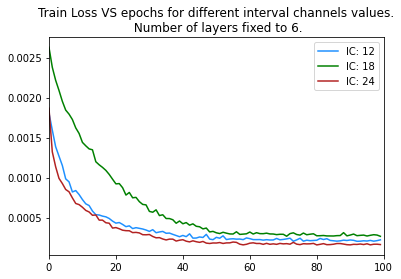

In [10]:
#@title
# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics12_6['loss_train'])/133, color='dodgerblue', label='IC: 12')
plt.plot(epochs_list, np.array(metrics18_6['loss_train'])/133, color='g', label='IC: 18')
plt.plot(epochs_list, np.array(metrics24_6['loss_train'])/133, color='firebrick', label='IC: 24')

plt.legend()
plt.title('Train Loss VS epochs for different interval channels values.\n Number of layers fixed to 6.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_train_IC.png'), bbox_inches = 'tight')

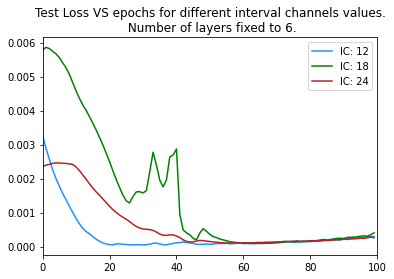

In [11]:
#@title

# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics12_6['loss_test'])/49, color='dodgerblue', label='IC: 12')
plt.plot(epochs_list, np.array(metrics18_6['loss_test'])/49, color='g', label='IC: 18')
plt.plot(epochs_list, np.array(metrics24_6['loss_test'])/49, color='firebrick', label='IC: 24')

plt.legend()
plt.title('Test Loss VS epochs for different interval channels values.\n Number of layers fixed to 6.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_test_IC.png'), bbox_inches = 'tight')

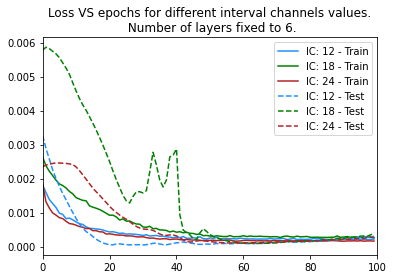

In [12]:
#@title

# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics12_6['loss_train'])/133, color='dodgerblue', label='IC: 12 - Train')
plt.plot(epochs_list, np.array(metrics18_6['loss_train'])/133, color='g', label='IC: 18 - Train')
plt.plot(epochs_list, np.array(metrics24_6['loss_train'])/133, color='firebrick', label='IC: 24 - Train')
plt.plot(epochs_list, np.array(metrics12_6['loss_test'])/49, color='dodgerblue', label='IC: 12 - Test', ls='--')
plt.plot(epochs_list, np.array(metrics18_6['loss_test'])/49, color='g', label='IC: 18 - Test', ls='--')
plt.plot(epochs_list, np.array(metrics24_6['loss_test'])/49, color='firebrick', label='IC: 24 - Test', ls='--')

plt.legend()
plt.title('Loss VS epochs for different interval channels values.\n Number of layers fixed to 6.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_both_IC.png'), bbox_inches = 'tight')

#### STOI VS Epoch

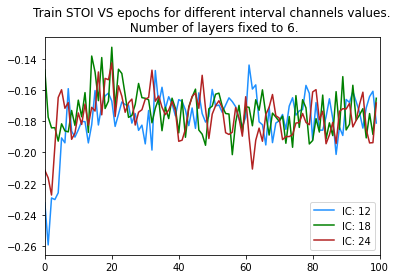

In [36]:
#@title

# Plot STOI vs epoch

# number of epochs as a list
epochs_list = list(range(100))
stoi_pred, stoi_mix = metrics12_6['stoi_train_pred'], metrics12_6['stoi_train_mix']
stoi_ecart_12_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics18_6['stoi_train_pred'], metrics18_6['stoi_train_mix']
stoi_ecart_18_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_6['stoi_train_pred'], metrics24_6['stoi_train_mix']
stoi_ecart_24_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]

# Plot
plt.plot(epochs_list, stoi_ecart_12_6, color='dodgerblue', label='IC: 12')
plt.plot(epochs_list, stoi_ecart_18_6, color='g', label='IC: 18')
plt.plot(epochs_list, stoi_ecart_24_6, color='firebrick', label='IC: 24')

plt.legend()
plt.title('Train STOI VS epochs for different interval channels values.\n Number of layers fixed to 6.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'STOI_train.png'), bbox_inches = 'tight')

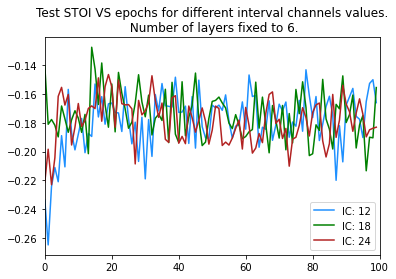

In [46]:
#@title

# Plot STOI vs epoch

# number of epochs as a list
epochs_list = list(range(100))
stoi_pred, stoi_mix = metrics12_6['stoi_test_pred'], metrics12_6['stoi_test_mix']
stoi_ecart_12_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics18_6['stoi_test_pred'], metrics18_6['stoi_test_mix']
stoi_ecart_18_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_6['stoi_test_pred'], metrics24_6['stoi_test_mix']
stoi_ecart_24_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]

# Plot
plt.plot(epochs_list, stoi_ecart_12_6, color='dodgerblue', label='IC: 12')
plt.plot(epochs_list, stoi_ecart_18_6, color='g', label='IC: 18')
plt.plot(epochs_list, stoi_ecart_24_6, color='firebrick', label='IC: 24')

plt.legend()
plt.title('Test STOI VS epochs for different interval channels values.\n Number of layers fixed to 6.')
plt.xlim([0,100])

### 3.5.3 - Analyse pour différents layers : 6, 10 et 12

Interval channels est fixé à 24.

#### Loss VS Epoch

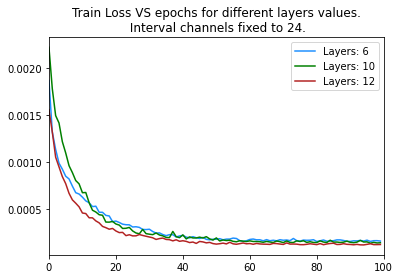

In [51]:
#@title

# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics24_6['loss_train'])/133, color='dodgerblue', label='Layers: 6')
plt.plot(epochs_list, np.array(metrics24_10['loss_train'])/133, color='g', label='Layers: 10')
plt.plot(epochs_list, np.array(metrics24_12['loss_train'])/133, color='firebrick', label='Layers: 12')

plt.legend()
plt.title('Train Loss VS epochs for different layers values.\n Interval channels fixed to 24.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_train_LAY.png'), bbox_inches = 'tight')

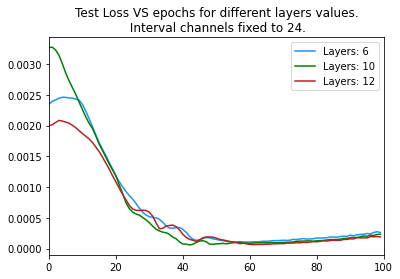

In [52]:
#@title

# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics24_6['loss_test'])/49, color='dodgerblue', label='Layers: 6')
plt.plot(epochs_list, np.array(metrics24_10['loss_test'])/49, color='g', label='Layers: 10')
plt.plot(epochs_list, np.array(metrics24_12['loss_test'])/49, color='firebrick', label='Layers: 12')

plt.legend()
plt.title('Test Loss VS epochs for different layers values.\n Interval channels fixed to 24.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_test_LAY.png'), bbox_inches = 'tight')

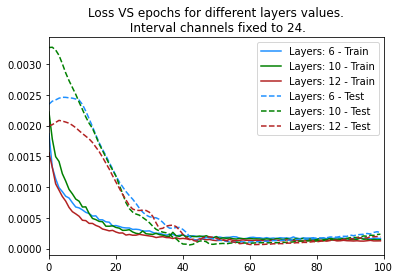

In [53]:
#@title

# Plot LOSS vs epoch

# number of epochs as a list
epochs_list = list(range(100))

# Plot
plt.plot(epochs_list, np.array(metrics24_6['loss_train'])/133, color='dodgerblue', label='Layers: 6 - Train')
plt.plot(epochs_list, np.array(metrics24_10['loss_train'])/133, color='g', label='Layers: 10 - Train')
plt.plot(epochs_list, np.array(metrics24_12['loss_train'])/133, color='firebrick', label='Layers: 12 - Train')
plt.plot(epochs_list, np.array(metrics24_6['loss_test'])/49, color='dodgerblue', label='Layers: 6 - Test', ls='--')
plt.plot(epochs_list, np.array(metrics24_10['loss_test'])/49, color='g', label='Layers: 10 - Test', ls='--')
plt.plot(epochs_list, np.array(metrics24_12['loss_test'])/49, color='firebrick', label='Layers: 12 - Test', ls='--')

plt.legend()
plt.title('Loss VS epochs for different layers values.\n Interval channels fixed to 24.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'losses_BOTH_LAY.png'), bbox_inches = 'tight')

#### STOI VS Epoch

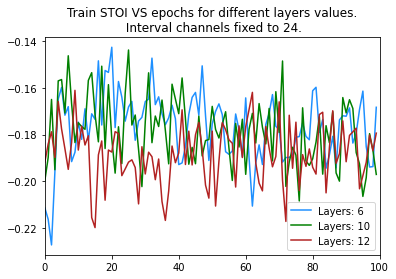

In [50]:
#@title

# Plot STOI vs epoch

# number of epochs as a list
epochs_list = list(range(100))
stoi_pred, stoi_mix = metrics24_6['stoi_train_pred'], metrics24_6['stoi_train_mix']
stoi_ecart_24_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_10['stoi_train_pred'], metrics24_10['stoi_train_mix']
stoi_ecart_24_10 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_12['stoi_train_pred'], metrics24_12['stoi_train_mix']
stoi_ecart_24_12 = [x - y for x, y in zip(stoi_pred, stoi_mix)]

# Plot
plt.plot(epochs_list, stoi_ecart_24_6, color='dodgerblue', label='Layers: 6')
plt.plot(epochs_list, stoi_ecart_24_10, color='g', label='Layers: 10')
plt.plot(epochs_list, stoi_ecart_24_12, color='firebrick', label='Layers: 12')

plt.legend()
plt.title('Train STOI VS epochs for different layers values.\n Interval channels fixed to 24.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'stoi_train_LAY.png'), bbox_inches = 'tight')

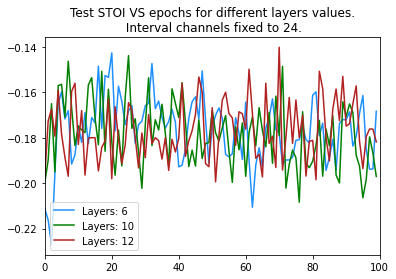

In [60]:
#@title

# Plot STOI vs epoch

# number of epochs as a list
epochs_list = list(range(100))
stoi_pred, stoi_mix = metrics24_6['stoi_test_pred'], metrics24_6['stoi_test_mix']
stoi_ecart_24_6 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_10['stoi_test_pred'], metrics24_10['stoi_test_mix']
stoi_ecart_24_10 = [x - y for x, y in zip(stoi_pred, stoi_mix)]
stoi_pred, stoi_mix = metrics24_12['stoi_test_pred'], metrics24_12['stoi_test_mix']
stoi_ecart_24_12 = [x - y for x, y in zip(stoi_pred, stoi_mix)]

# Plot
plt.plot(epochs_list, stoi_ecart_24_6, color='dodgerblue', label='Layers: 6')
plt.plot(epochs_list, stoi_ecart_24_10, color='g', label='Layers: 10')
plt.plot(epochs_list, stoi_ecart_24_12, color='firebrick', label='Layers: 12')

plt.legend()
plt.title('Test STOI VS epochs for different layers values.\n Interval channels fixed to 24.')
plt.xlim([0,100])
plt.savefig(os.path.join(path_img, 'stoi_test_LAY.png'), bbox_inches = 'tight')

# 5 - Résultats qualitatifs

On écoute le signal 'clean' obtenu grâce au modèle.

### 5.1 - Chargement du modèle

In [ ]:
#@title
# Initialize model
network = Model(12, 24)
# Load with .pth
path_network = os.path.join(path_models, 'model_v1_20-12-2022.pth')

# Rename layers so it matches with updated model
ckpt = torch.load(path_network, map_location=device)
ckpt['output_layer.0.weight'] = ckpt['out.0.weight']
del ckpt['out.0.weight']
ckpt['output_layer.0.bias'] = ckpt['out.0.bias']
del ckpt['out.0.bias']
# Load the model
network.load_state_dict(ckpt)

<All keys matched successfully>

### 5.2 - Chargement des données

#### Fonction qui renvoie le signal prédit

In [ ]:
#@title
def get_signal(y_bruit, y_voix):
  ''' Renvoie le signal prédit prêt à être écouter à partir de la prédiction
  '''
  # Calcul du mix, de la voix et du bruit (normalized)
  y_mix_norm, (y_voix_norm, y_bruit_norm) = get_data(y_bruit, y_voix)

  # ToTensor
  y_mix_tensor = torch.tensor(y_mix_norm)
  y_voix_tensor = torch.from_numpy(y_voix_norm)
  y_bruit_tensor = torch.from_numpy(y_bruit_norm)

  # to device
  y_mix_tensor = y_mix_tensor.to(device)
  y_voix_tensor = y_voix_tensor.to(device)
  y_bruit_tensor = y_bruit_tensor.to(device)

  # split to make different prediction
  y1, y2 = y_mix_tensor[:input_size], y_mix_tensor[(input_size+1):2*input_size+1], 
  y3, y4 = y_mix_tensor[(2*input_size+2):3*input_size+2], y_mix_tensor[(3*input_size+3):4*input_size+3]
  mix = torch.cat((y1, y2, y3, y4))
  mix = mix.view(4, 1, input_size)
  pred = network(mix)
  # Tensor to Array
  pred_cpu = pred.view(4*input_size).cpu().detach().numpy()
  y_voix_cpu = y_voix_tensor.cpu().detach().numpy()
  y_mix_cpu = y_mix_tensor.cpu().detach().numpy()

  return pred_cpu, y_voix_cpu, y_mix_cpu

#### Résultats n°1/3

In [ ]:
#@title
# Size of the input of the model
input_size = 16384
path_bruit_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/bruit_test/test"
path_voix_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/voix_test/test"

# Chargement du bruit
path_file = os.path.join(path_bruit_test, 'street_pedestrian-barcelona-144-4348-a.wav')
y_bruit, sr_bruit = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Chargement de la voix
path_file = os.path.join(path_voix_test, 'Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap03_2_.wav')
y_voix, sr_voix = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Get predicted signals reconstructed
pred_cpu, y_voix_cpu, y_mix_cpu = get_signal(y_bruit, y_voix)

In [ ]:
#@title
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap03_2_barcelona_mix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_mix_cpu, sr_voix)
# Display MIX audio to listen
ipd.Audio(y_mix_cpu, rate = sr_voix)

In [ ]:
#@title
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap03_2_barcelona_voix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_voix_cpu, sr_voix)
# Display VOICE audio to listen
ipd.Audio(y_voix_cpu, rate = sr_voix)

In [ ]:
#@title
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap03_2_barcelona_pred.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, pred_cpu, sr_voix)
# Display PREDICTION audio to listen
ipd.Audio(pred_cpu, rate = sr_voix)

#### Résultats n°2/3

In [ ]:
#@title
# Size of the input of the model
input_size = 16384
path_bruit_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/bruit_test/test"
path_voix_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/voix_test/test"

# Chargement du bruit
path_file = os.path.join(path_bruit_test, 'street_pedestrian-helsinki-147-4450-a.wav')
y_bruit, sr_bruit = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Chargement de la voix
path_file = os.path.join(path_voix_test, 'Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap11_143_.wav')
y_voix, sr_voix = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Get predicted signals reconstructed
pred_cpu, y_voix_cpu, y_mix_cpu = get_signal(y_bruit, y_voix)

In [ ]:
#@title
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap11_143_helsinki_mix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_mix_cpu, sr_voix)
# Display MIX audio to listen
ipd.Audio(y_mix_cpu, rate = sr_voix)

In [ ]:
#@title
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap11_143_helsinki_voix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_voix_cpu, sr_voix)
# Display VOICE audio to listen
ipd.Audio(y_voix_cpu, rate = sr_voix)

In [ ]:
#@title
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap11_143_helsinki_pred.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, pred_cpu, sr_voix)
# Display PREDICTION audio to listen
ipd.Audio(pred_cpu, rate = sr_voix)

#### Résultats n°3/3

In [ ]:
#@title
# Size of the input of the model
input_size = 16384
path_bruit_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/bruit_test/test"
path_voix_test = "/content/drive/MyDrive/ENS_MVA/I&I_Signal/TP4/data/voix_test/test"

# Chargement du bruit
path_file = os.path.join(path_bruit_test, 'street_pedestrian-lisbon-1174-45124-a.wav')
y_bruit, sr_bruit = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Chargement de la voix
path_file = os.path.join(path_voix_test, 'Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap07_108_.wav')
y_voix, sr_voix = librosa.load(path = path_file, sr=None) # audio time series, sampling rate

# Get predicted signals reconstructed
pred_cpu, y_voix_cpu, y_mix_cpu = get_signal(y_bruit, y_voix)

- Mix, voix originale et prédiction

In [ ]:
#@title
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap07_108_lisbon_mix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_mix_cpu, sr_voix)
# Display MIX audio to listen
ipd.Audio(y_mix_cpu, rate = sr_voix)

In [ ]:
#@title
# Display VOICE audio to listen
# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap07_108_lisbon_voix.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, y_voix_cpu, sr_voix)
ipd.Audio(y_voix_cpu, rate = sr_voix)

In [ ]:
#@title
# Display PREDICTION audio to listen

# Path to save the file
path_results_audio = os.path.join(path_project, 'results_audio')
name_audio = 'Chap07_108_lisbon_prediction.wav'
path_tosave = os.path.join(path_results_audio, name_audio)
# Save it
sf.write(path_tosave, pred_cpu, sr_voix)
# Listen to it
ipd.Audio(pred_cpu, rate = sr_voix)

# Conclusion

- Le modèle parvient bien à diminuer le fond sonore considéré comme bruit dans la plupart des cas.

- Toutefois, il arrive que la qualité de la voix soit endommagée lors de l'amélioration de voix.

- Lorsqu'une voix humaine est présente dans le bruit, elle est atténuée mais elle reste présente si l'intonation est forte.

Ce TP m'a permis de découvrir l'architecture de modèle U-Net/Wave-U-Net, d'implémenter cette architecture et de la tester dans le cadre de réduction de bruit. De plus, différentes versions de l'architecture ont été comparées. 

On remarque que même si la loss function diminue, la STOI ne diminue pas toujours car même si le modèle parvient à réduire le bruit, cette réduction a un coût : la baisse de qualité de la voix originale dans le signal reconstruit/

# Références

- Wave-U-Net : https://arxiv.org/abs/1806.03185

- U-Net : https://arxiv.org/abs/1505.04597

- STOI : https://arxiv.org/pdf/1806.03185.pdf

# FIN

Merci pour votre lecture !

Théo Di Piazza - theo.dipiazza@gmail.com

Janvier 2023

---

In [65]:
# Command to save the file as HTML
! jupyter nbconvert --to html /content/drive/MyDrive/ENS_MVA/II_Signal/TP4/II_Signal_DIPIAZZA_Theo_Project.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/ENS_MVA/II_Signal/TP4/II_Signal_DIPIAZZA_Theo_Project.ipynb to html
[NbConvertApp] Writing 2783700 bytes to /content/drive/MyDrive/ENS_MVA/II_Signal/TP4/II_Signal_DIPIAZZA_Theo_Project.html
